In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import statistics
from sklearn.metrics import roc_curve, auc
import pickle
from collections import Counter

In [5]:
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import SVD
from surprise.prediction_algorithms import knns
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold

# 1: Sparsity

In [6]:
#Load Data
df = pd.read_csv('data/ml-latest-small/ratings.csv')

In [7]:
# sparsity = total available/total possible
no_users = len(df['userId'].unique())
no_movies = len(df['movieId'].unique())
sparsity = 1 - (len(df) / (no_users * no_movies))
print('----------Report-------------')
print('Sparsity is:', sparsity)
print('-----------------------------')

----------Report-------------
Sparsity is: 0.9835608583913366
-----------------------------


# 2: Frequency Histogram

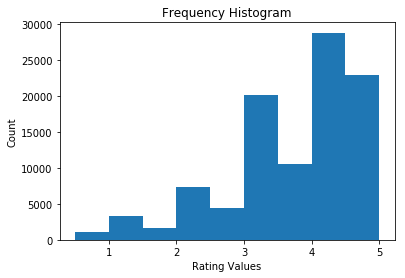

In [8]:
ratings = df['rating']
ratings = list(ratings)
binwidth = 0.5
plt.hist(ratings, bins=np.arange(min(ratings), max(ratings) + binwidth, binwidth))
plt.xlabel('Rating Values')
plt.ylabel('Count')
plt.title('Frequency Histogram')
plt.show()

# 3: Distribution of Ratings among Movies

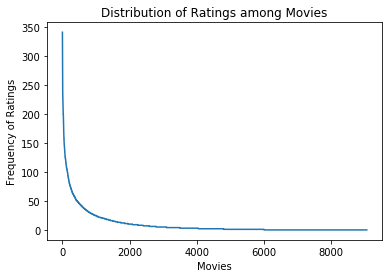

In [9]:
movie_distr = df['movieId'].value_counts()
plt.plot(list(movie_distr))
plt.xlabel('Movies')
plt.ylabel('Frequency of Ratings')
plt.title('Distribution of Ratings among Movies')
plt.show()

# 4: Distribution of Ratings among Users

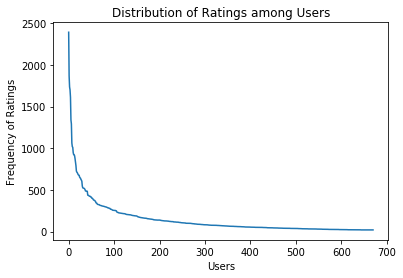

In [10]:
user_distr = df['userId'].value_counts()
plt.plot(list(user_distr))
plt.xlabel('Users')
plt.ylabel('Frequency of Ratings')
plt.title('Distribution of Ratings among Users')
plt.show()

# 5: Explain 3 - Report

# 6: Variance of Rating Values

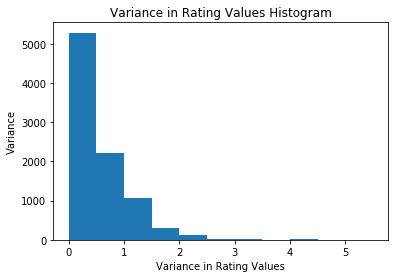

In [11]:
var_rating = df[['movieId', 'rating']].groupby('movieId').var(ddof=0)
var_rating = var_rating.dropna()
var_rating = list(var_rating['rating'])
binwidth = 0.5
plt.hist(var_rating, bins=np.arange(min(var_rating), max(var_rating) + binwidth, binwidth))
plt.xlabel('Variance in Rating Values')
plt.ylabel('Variance')
plt.title('Variance in Rating Values Histogram')
plt.show()

# 7: Formula for Uu in terms of Iu and ruk

In [12]:
%%latex
\[ \mu_u  = \frac{\sum_{k \epsilon I_u} r_{uk}}{\sum I_{u}} \]

<IPython.core.display.Latex object>

# 8: Explain
### Iu intersection Iv :- This means we are trying to find the set of items that both the users u and v have rated.
### Can Iu intersection Iv = nullset :- Yes, it can!
### Iu intersection Iv = nullset :- If the set of items that both the users have rated is empty, it means that the users u and v have no items common to each other. This also indicates that the users u and v are very unlikely to be neighbours.

# 9:Explain
### //TODO

# 10:Design a k-NN collaborative filter to predict the ratings of the movies

In [13]:
load_model = True
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

if not load_model:
    sim_options = {'name': 'pearson',
                   'user_based': True  # compute  similarities between items
                   }
    list_k = range(2,101, 2)
    print(list(list_k))
    val = []
    for k in list_k:
        model = knns.KNNBasic(k=k, min_k=1, sim_options=sim_options)
        val.append(cross_validate(model, data, measures=['RMSE', 'MAE'], cv=10, verbose=False))

    #Dump the results to knnFull.pkl
    with open('models/knnFull.pkl','wb') as f:
        pickle.dump(val,f)
else:
    val = pickle.load(open('models/knnFull.pkl','rb'))

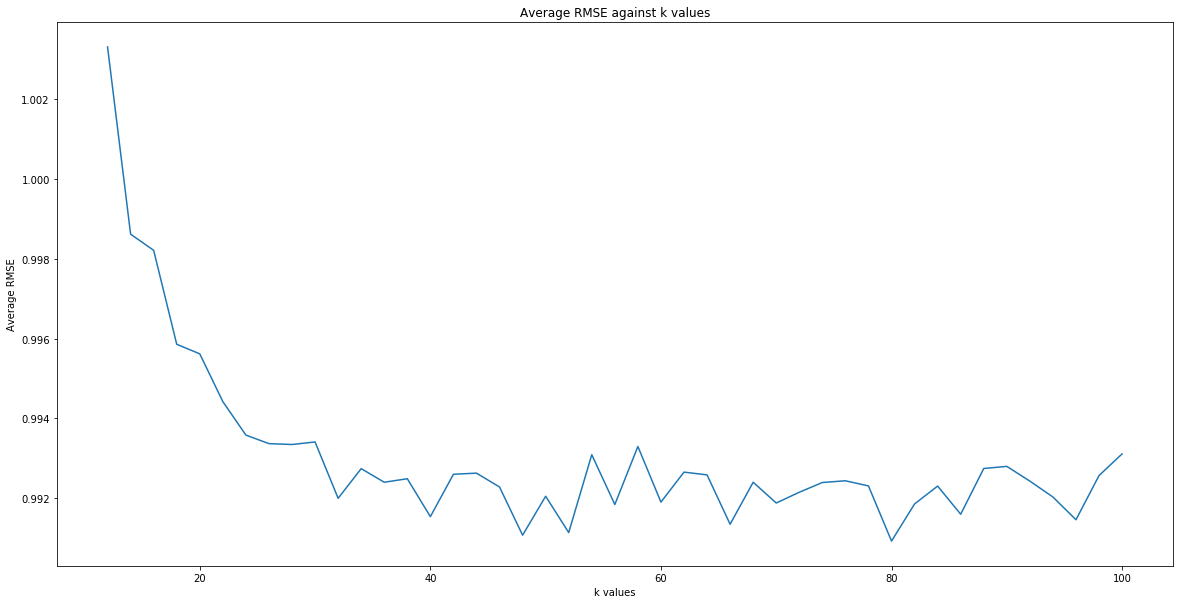

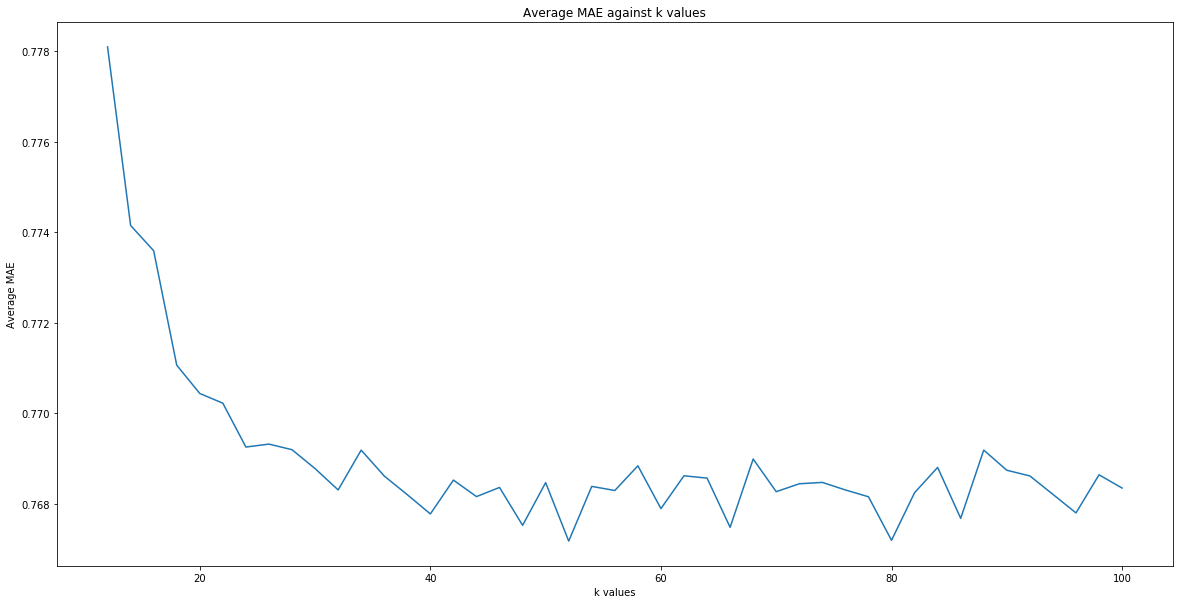

In [16]:
mean_rmse = []
mean_mae = []
for i in range(len(val)):
    mean_rmse.append(sum(val[i]['test_rmse'])/len(val[i]['test_rmse']))
    mean_mae.append(sum(val[i]['test_mae'])/len(val[i]['test_mae']))

plt.figure(figsize=(20,10))
plt.plot(range(12,101,2), mean_rmse[5:])

plt.xlabel('k values')
plt.ylabel('Average RMSE')
plt.title('Average RMSE against k values')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(range(12,101,2), mean_mae[5:])

plt.xlabel('k values')
plt.ylabel('Average MAE')
plt.title('Average MAE against k values')
plt.show()


# 11: Find minimum k

In [17]:
diff_mean_rmse = [sum([mean_rmse[i]-k for k in mean_rmse[i:]]) for i in range(len(mean_rmse))]
# plt.plot(range(2,101,2), diff_mean_rmse)
# plt.xlabel('k values')
# plt.ylabel('diff Average RMSE')
# plt.title('diff Average RMSE against k values')
# plt.show()
print('minimum k with RMSE=', 2*mean_rmse.index(mean_rmse[diff_mean_rmse.index(min(diff_mean_rmse))]))

minimum k with RMSE= 46


In [18]:
diff_mean_mae = [sum([mean_mae[i]-k for k in mean_mae[i:]]) for i in range(len(mean_mae))]
# plt.plot(range(2,101,2), diff_mean_mae)
# plt.xlabel('k values')
# plt.ylabel('diff Average MAE')
# plt.title('diff Average MAE against k values')
# plt.show()
print('minimum k with MAE=', 2*mean_mae.index(mean_mae[diff_mean_mae.index(min(diff_mean_mae))]))

minimum k with MAE= 50


### Hence, we can conclude that k=46 is a good convergence point for both MAE and RMSE.

In [19]:
# RMSE and MAE with k = 46
min_k = 46
print('Average RMSE for minimum k is:', mean_rmse[min_k//2], 'Average MAE for minimum k is:', mean_mae[min_k//2])

Average RMSE for minimum k is: 0.9910785169037102 Average MAE for minimum k is: 0.7675210844325601


# Methods to trim the dataset into the popular, unpopular and high variance groups

In [20]:
#Function to trim to dataset to only the popular movies
def trim_popular(testset):
    
    counts = Counter(test[1] for test in testset)
    res = []
    for test in testset:
        if counts[test[1]] > 2:
            res.append(test)
    return res

#function to trim the dataset to only the unpopular movies
def trim_unpopular(testset):
    counts = Counter(test[1] for test in testset)
    res = []
    for test in testset:
        if counts[test[1]] <= 2:
            res.append(test)
    return res

#function to trim the dataset to popular movies with a high rating variance
def trim_highVar(testset):
    counts = Counter(test[1] for test in testset)
    variance = {}

    for movieId in counts.keys():
        minRating = 10
        maxRating = -1
        for test in testset:
            if test[1] == movieId:
                if test[2] > maxRating:
                    maxRating = test[2]
                elif test[2] < minRating:
                    minRating = test[2]
        variance[movieId] = maxRating - minRating
    res = []
    for test in testset:
        if counts[test[1]] >=5 and variance[test[1]] >=2:
            res.append(test)
    return res

# 12,13,14: Training the K-NN collaborative filter and testing on 3 trimmed datasets

In [21]:
load_models = True
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

if not load_models:
    
    sim_options = {'name': 'pearson',
                   'user_based': True  # compute  similarities between items
                   }
    kf = KFold(n_splits = 10)

    list_k = range(2,101, 2)
    print(list(list_k))

    val_popular = []
    val_unpopular = []
    val_highVar = []

    for k in list_k:
        model = knns.KNNBasic(k=k, min_k=1, sim_options=sim_options)
    
        valFold_popular = []
        valFold_unpopular = []
        valFold_highVar = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            #Get the trimmed testet
            popular_trimmed_testset = trim_popular(testset)
            unpopular_trimmed_testset = trim_unpopular(testset)
            highVariance_testset = trim_highVar(testset)
        
            predictions_popular = model.test(popular_trimmed_testset)
            predictions_unpopular = model.test(unpopular_trimmed_testset)
            predictions_highVar = model.test(highVariance_testset)
        
            valFold_popular.append([accuracy.rmse(predictions_popular,verbose = False),
                                    accuracy.mae(predictions_popular,verbose = False)])
            valFold_unpopular.append([accuracy.rmse(predictions_unpopular,verbose = False),
                                      accuracy.mae(predictions_unpopular,verbose = False)])
            valFold_highVar.append([accuracy.rmse(predictions_highVar,verbose = False),
                                    accuracy.mae(predictions_highVar,verbose = False)])
        
        val_popular.append(valFold_popular)
        val_unpopular.append(valFold_unpopular)
        val_highVar.append(valFold_highVar)

    #Dump the results
    with open('models/knnTrimPopular.pkl','wb') as f:
        pickle.dump(val_popular,f)
    
    with open('models/knnTrimUnpopular.pkl','wb') as f:
        pickle.dump(val_unpopular,f)
    
    with open('models/knnTrimHighVar.pkl','wb') as f:
        pickle.dump(val_highVar,f)
        
else:
    val_popular = pickle.load(open('models/knnTrimPopular.pkl','rb'))
    val_unpopular = pickle.load(open('models/knnTrimUnpopular.pkl','rb'))
    val_highVar = pickle.load(open('models/knnTrimHighVar.pkl','rb'))

# 12: RMSE results for the popular trimmed dataset with K-NN collaborative filter

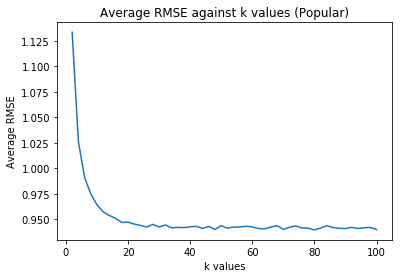


 Minimum Average RMSE is: 0.9396780372414136


In [22]:
mean_rmse = []
mean_mae = []
for i in range(len(val_popular)):
    npArr = np.array(val_popular[i])
    mean_rmse.append(sum(npArr[:,0])/len(npArr[:,0]))
    mean_mae.append(sum(npArr[:,1])/len(npArr[:,1]))

plt.plot(range(2,101,2), mean_rmse)
plt.xlabel('k values')
plt.ylabel('Average RMSE')
plt.title('Average RMSE against k values (Popular)')
plt.show()

#Don't need MAE for now
#plt.plot(range(2,101,2), mean_mae)
#plt.xlabel('k values')
#plt.ylabel('Average MAE')
#plt.title('Average MAE against k values (Popular)')
#plt.show()

print('\n Minimum Average RMSE is:', min(mean_rmse))

# 13: RMSE results for the unpopular trimmed dataset with K-NN collaborative filter

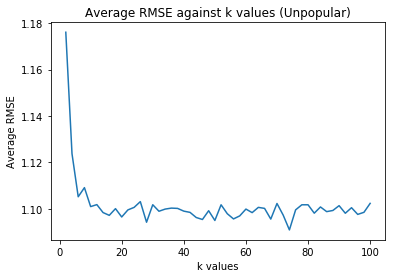


 Minimum Average RMSE is: 1.0909547518041958


In [23]:
mean_rmse = []
mean_mae = []
for i in range(len(val_unpopular)):
    npArr = np.array(val_unpopular[i])
    mean_rmse.append(sum(npArr[:,0])/len(npArr[:,0]))
    mean_mae.append(sum(npArr[:,1])/len(npArr[:,1]))

plt.plot(range(2,101,2), mean_rmse)
plt.xlabel('k values')
plt.ylabel('Average RMSE')
plt.title('Average RMSE against k values (Unpopular)')
plt.show()

#Don't need MAE for now
#plt.plot(range(2,101,2), mean_mae)
#plt.xlabel('k values')
#plt.ylabel('Average MAE')
#plt.title('Average MAE against k values (Unpopular)')
#plt.show()

print('\n Minimum Average RMSE is:', min(mean_rmse))

# 14: RMSE results for the high variance trimmed dataset with K-NN collaborative filter

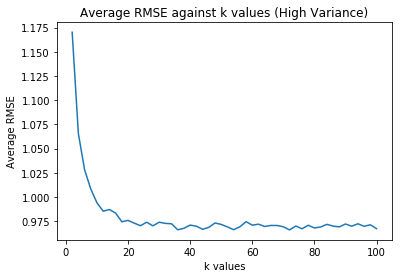


 Minimum Average RMSE is: 0.9660177022127036


In [24]:
mean_rmse = []
mean_mae = []
for i in range(len(val_highVar)):
    npArr = np.array(val_highVar[i])
    mean_rmse.append(sum(npArr[:,0])/len(npArr[:,0]))
    mean_mae.append(sum(npArr[:,1])/len(npArr[:,1]))

plt.plot(range(2,101,2), mean_rmse)
plt.xlabel('k values')
plt.ylabel('Average RMSE')
plt.title('Average RMSE against k values (High Variance)')
plt.show()

#Don't need MAE for now
#plt.plot(range(2,101,2), mean_mae)
#plt.xlabel('k values')
#plt.ylabel('Average MAE')
#plt.title('Average MAE against k values (High Variance)')
#plt.show()

print('\n Minimum Average RMSE is:', min(mean_rmse))

# 15: ROC Curve for kNN filter

In [72]:
trainset, testset = train_test_split(data, test_size=.10)
sim_options = {'name': 'pearson',
                   'user_based': True  # compute  similarities between items
              }
model = knns.KNNBasic(k=min_k, min_k=1, sim_options=sim_options, verbose=False)
predictions = model.fit(trainset).test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
10001


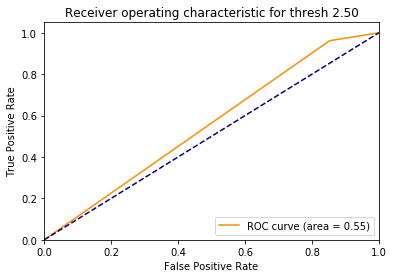

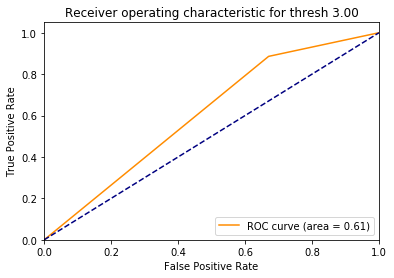

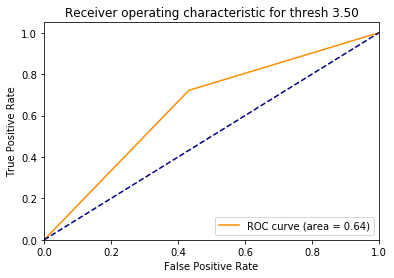

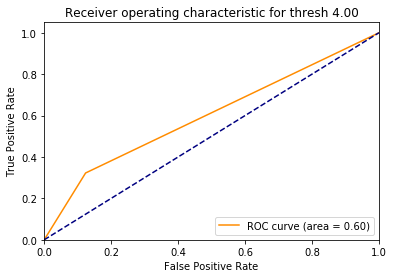

In [93]:
thresholds = [2.5, 3, 3.5, 4]
y_true = [pred[2] for pred in predictions]
y_pred = [pred[3] for pred in predictions]
for thresh in thresholds:
    y_t = list((map(lambda x : 0 if x<thresh else 1,y_true)))
    y_p = list((map(lambda x : 0 if x<thresh else 1,y_pred)))
    fpr, tpr, threshs = metrics.roc_curve(y_t, y_p)
    roc_auc = auc(fpr, tpr)    
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for thresh %0.2f' % thresh)
    plt.legend(loc="lower right")
    plt.show()

# 16: Explain some theory - Think about it while making report

# 17: NNMF-based collaborative filter